In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap
from models import JointLatentDiffusionNoisyClassifier
from datasets import AdjustedSVHN, AdjustedMNIST, AdjustedFashionMNIST

/home/pawel/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-25 15:09:08.610883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 15:09:09.462084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-25 15:09:09.462163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.

In [2]:
config = OmegaConf.load("configs/fashion-joint-diffusion.yaml")
config.model.params["ckpt_path"] = f"logs/JointDiffusion_2023-04-24T22-09-09/checkpoints/last.ckpt"
model = JointLatentDiffusionNoisyClassifier(**config.model.get("params", dict()))

JointLatentDiffusionNoisyClassifier: Running in eps-prediction mode
DiffusionWrapper has 67.45 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 8, 8) = 256 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from logs/Autoencoder_2023-04-22T19-21-23/checkpoints/last.ckpt
Training JointLatentDiffusionNoisyClassifier as an unconditional model.
Restored from logs/JointDiffusion_2023-04-24T22-09-09/checkpoints/last.ckpt with 0 missing and 4 unexpected keys
Unexpected Keys: ['classifier.0.weight', 'classifier.0.bias', 'classifier.4.weight', 'classifier.4.bias']
Restored from logs/JointDiffusion_2023-04-24T22-09-09/checkpoints/last.ckpt with 0 missing and 0 unexpected keys


In [3]:
dataset = AdjustedFashionMNIST(train=True)
dl = torch.utils.data.DataLoader(dataset, batch_size=128)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

JointLatentDiffusionNoisyClassifier(
  (model): DiffusionWrapper(
    (diffusion_model): AdjustedUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=160, out_features=640, bias=True)
        (1): SiLU()
        (2): Linear(in_features=640, out_features=640, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=640, out_features=160, bias=True)
            )
            (out_layers): Seque

In [5]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in tqdm(data_loader):
        with torch.no_grad():
            encoder_posterior = model.encode_first_stage(imgs.permute(0, 3, 1, 2).to(device))
            latent = model.get_first_stage_encoding(encoder_posterior).detach().flatten(start_dim=1)
        img_list.append(imgs)
        embed_list.append(latent)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

In [6]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(model, dl)
train_embedded = umap_object.fit_transform(train_img_embeds[1].cpu())

100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


In [16]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(24, 20))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        # alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

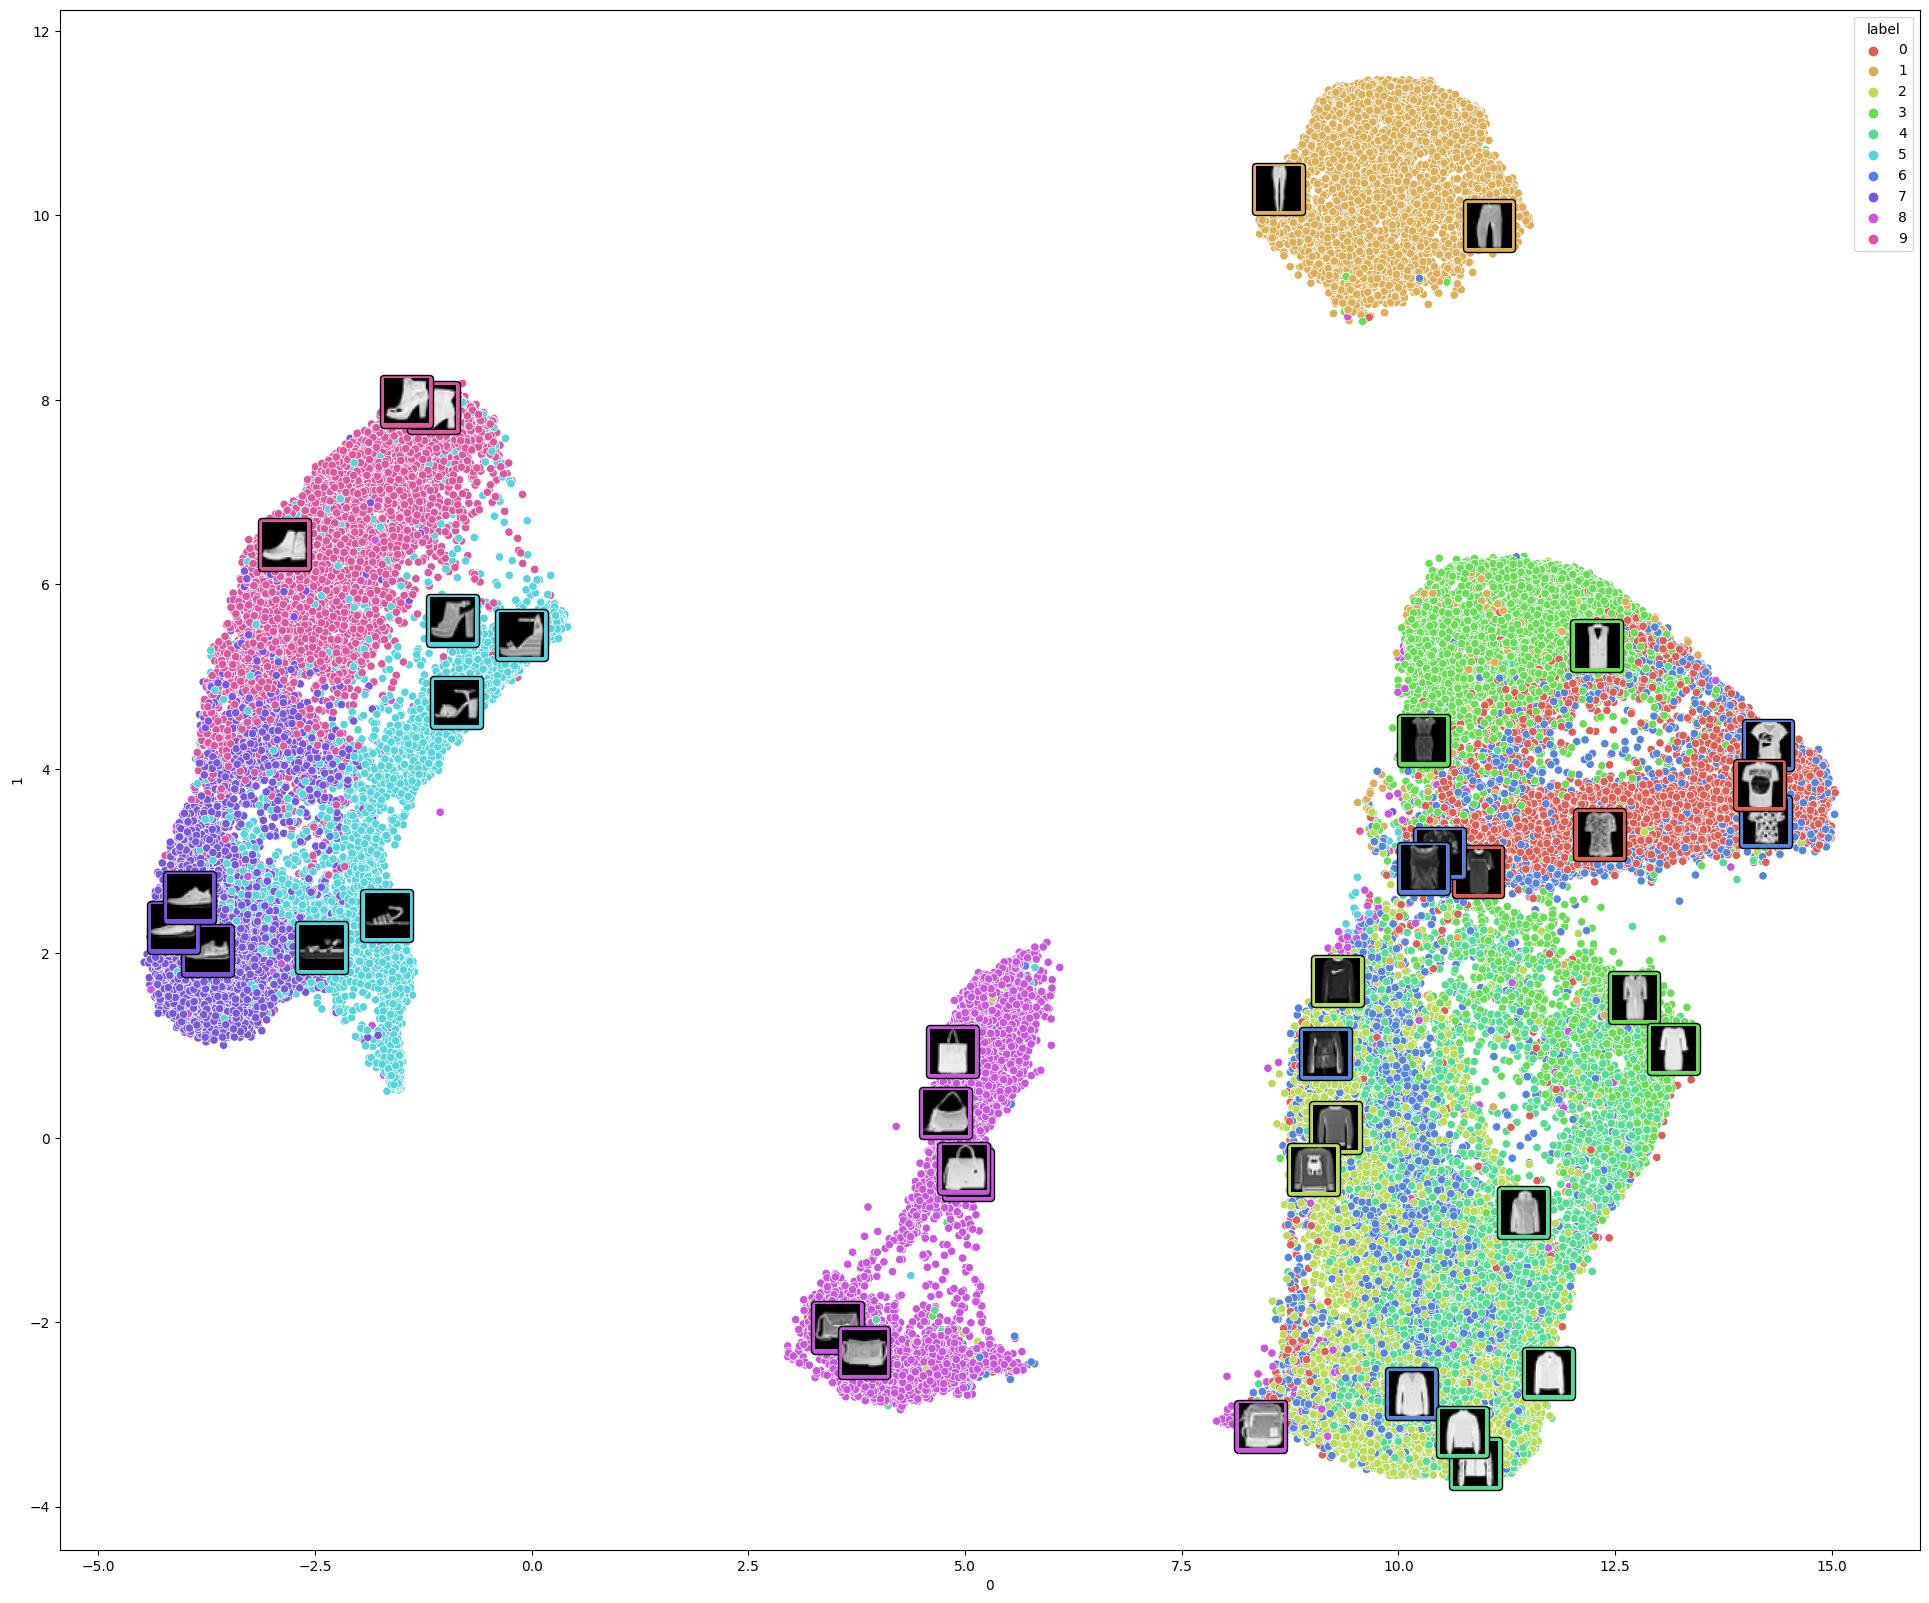

In [19]:
plot_latent(train_embedded, train_img_embeds, 60000)

In [54]:
from ldm.modules.diffusionmodules.util import noise_like
import torch.nn as nn


@torch.no_grad()
def get_diffusion_path(model, num_samples, sample_classes):
    shape = (num_samples, model.channels, model.image_size, model.image_size)
    b = shape[0]
    img = torch.randn(shape, device=device)
    intermediates = [img]
    timesteps = model.num_timesteps
    iterator = tqdm(reversed(range(0, timesteps)), desc='Sampling t', total=timesteps)

    for i in iterator:
        ts = torch.full((b,), i, device=device, dtype=torch.long)
        emb = model.model.diffusion_model.get_timestep_embedding(img, ts, None)

        # representations_with_grad = model.model.diffusion_model.forward_input_blocks(img, None, emb)
        with torch.enable_grad():
            representations = model.model.diffusion_model.forward_input_blocks(img, None, emb)
            for h in representations:
                h.retain_grad()
            pooled_representations = model.model.diffusion_model.pool_representations(representations)
            pooled_representations = [torch.flatten(z_i, start_dim=1) for z_i in pooled_representations]
            pooled_representations = torch.concat(pooled_representations, dim=1)
            class_predictions = model.classifier(pooled_representations)
            # loss = -torch.log(torch.gather(class_predictions, 1, self.sample_classes.unsqueeze(dim=1))).sum()
            loss = nn.functional.cross_entropy(class_predictions, sample_classes, reduction="sum")
            loss.backward()
            representations_with_grad = [(h + model.sample_grad_scale * h.grad).detach() for h in representations]

        model_out_no_grad = model.model.diffusion_model.forward_output_blocks(img, None, emb, representations)
        x_recon = model.predict_start_from_noise(img, t=ts, noise=model_out_no_grad)
        model_mean, _, model_log_variance = model.q_posterior(x_start=x_recon, x_t=img, t=ts)
        noise = noise_like(shape, device, False) * 1.0
        nonzero_mask = (1 - (ts == 0).float()).reshape(b, *((1,) * (len(shape) - 1)))
        img_no_grad = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        intermediates.append(img_no_grad.cpu())

        model_out_with_grad = model.model.diffusion_model.forward_output_blocks(img, None, emb, representations_with_grad)
        x_recon = model.predict_start_from_noise(img, t=ts, noise=model_out_with_grad)
        model_mean, _, model_log_variance = model.q_posterior(x_start=x_recon, x_t=img, t=ts)
        noise = noise_like(shape, device, False) * 1.0
        nonzero_mask = (1 - (ts == 0).float()).reshape(b, *((1,) * (len(shape) - 1)))
        img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        intermediates.append(img.cpu())
    return intermediates

In [170]:
model.sample_grad_scale = 300
diffusion_path = get_diffusion_path(model, 1, torch.tensor([0]).to(device))

Sampling t: 100%|██████████| 1000/1000 [01:03<00:00, 15.70it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


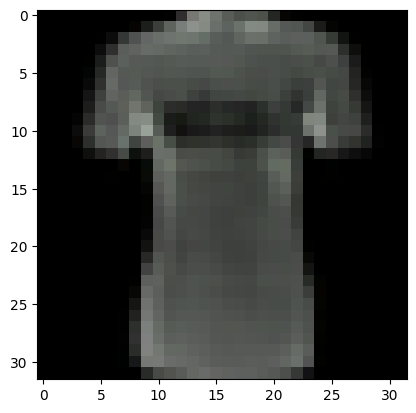

In [171]:
import torchvision as tv


samples = diffusion_path[-1]
samples = model.decode_first_stage(samples.to(model.device))
grid = tv.utils.make_grid(samples.cpu())
plt.imshow(grid.permute(1,2,0))
plt.show()

In [172]:
flattened = torch.cat([img.flatten(start_dim=1).cpu() for img in diffusion_path], dim=0)
path_emb = umap_object.transform(flattened)

In [173]:
def plot_diffusion(train_embedded, train_img_embeds, diffusion_path, samples, timesteps, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    # examples = []
    # examples_locations = []
    # for i in np.random.randint(0,n_data,40):
    #     examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
    #     examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(24, 20))

    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        size=2,
        # alpha=0.1
    )
    # colors = ["red", "blue", "brown", "yellow", "green", "pink", "orange", "black", "purple", "white"]
    for i in range(samples):
        colors = ["black", "red"]
        for j in range(timesteps):
            ax.plot(
                diffusion_path[i*timesteps+j:(i)*timesteps+j+2, 0],
                diffusion_path[i*timesteps+j:(i)*timesteps+j+2, 1],
                color=colors[j%2],
                marker=".",
                alpha=1,
                linewidth=1,
                markersize=1
            )
        # ax.plot(
        #     diffusion_path[i*timesteps:(i+1)*timesteps, 0],
        #     diffusion_path[i*timesteps:(i+1)*timesteps, 1],
        #     color="black",
        #     marker=1,
        #     alpha=1
        # )
        break
    # for location, example in zip(examples_locations, examples):
    #     x, y = location[0], location[1]
    #     label = int(location["label"])
    #     ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
    #                         bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    #     ax.add_artist(ab)
    plt.show()

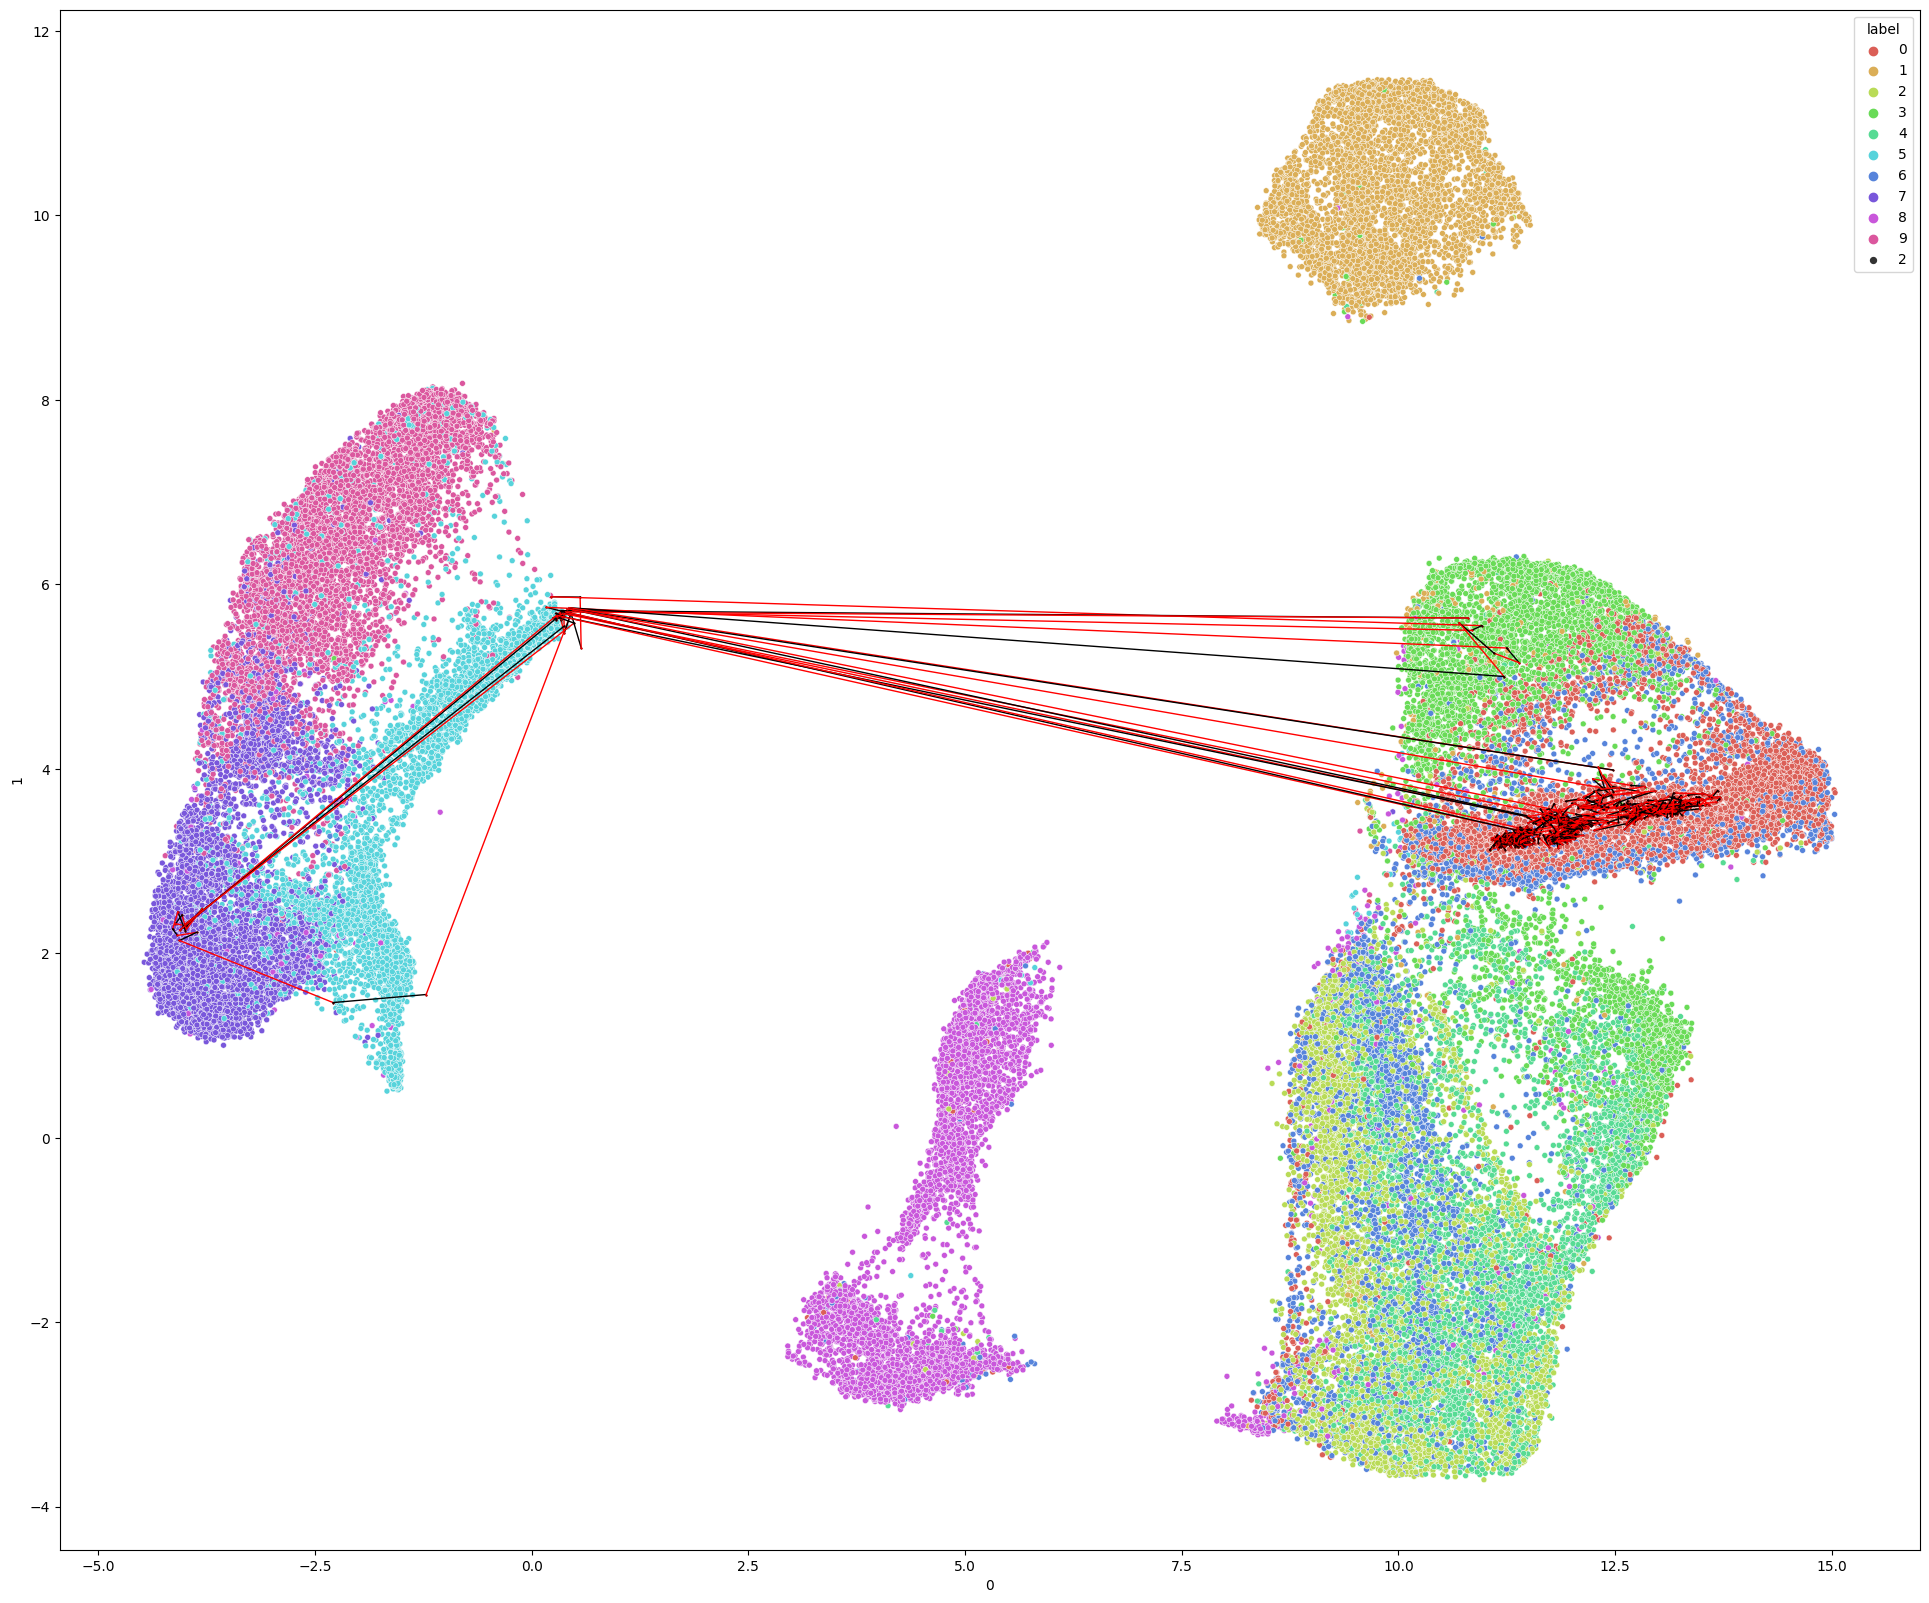

In [174]:
plot_diffusion(train_embedded, train_img_embeds, path_emb, 10, 1001, 60000)